In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

sns.set()
%matplotlib inline

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Click here to hide/print cells code</a>.''')


## Introduction

Ce jeu de donnée contient des candidatures pour le poste de chercheur d'or chez OrFée. 

Dans une première partie, nous concentrerons notre analyse sur l'étude des différentes variables présentes dans le jeu de donnée, leur distribution et leur dépendance. Ensuite, nous choisirons un modèle prédictif afin de prédire si un candidat donné sera embauché ou non en fonction de ses attributs.

## Chargement des données

In [2]:
candidates = pd.read_csv('data/data_v1.0.csv').drop(['Unnamed: 0', 'index'], axis=1)

In [3]:
candidates.head()

,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,2011-07-01,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


In [36]:
print('Nombre de lignes: {}\n'
      'Nombre de colonnes: {}'.format(*candidates.shape))

Nombre de lignes: 20000
Nombre de colonnes: 11


In [16]:
candidates.describe()

,age,exp,salaire,note,embauche
count,19909.000000,19904.000000,19905.000000,19886.000000,20000.000000
mean,35.004521,9.500352,34974.343934,75.168762,0.114600
std,9.609169,3.012109,5003.099616,17.095926,0.318547
min,-3.000000,-2.000000,14128.000000,8.680000,0.000000
25%,29.000000,7.000000,31596.000000,63.720000,0.000000
50%,35.000000,9.000000,34979.000000,75.080000,0.000000
75%,41.000000,12.000000,38358.000000,86.617500,0.000000
max,74.000000,23.000000,53977.000000,143.220000,1.000000


In [4]:
candidates.select_dtypes(include=['object']).describe()

,date,cheveux,sexe,diplome,specialite,dispo
count,19909,19897,19900,19890,19907,19894
unique,1826,4,2,4,4,2
top,2012-02-03,chatain,M,master,geologie,non
freq,24,6022,11889,7513,10028,11848


Un premier coup d'oeil au jeu de donnée nous donne quelques informations sur la distribution de certaines variables. Par exemple:
- Le salaire moyen des candidats est de 34k.
- La spécialité la plus commune des candidats est la géologie.

Nous observons également des incohérences et des valeurs manquante (environ 100/20000 par colonnes). Des valeurs négatives apparaissent pour les variables expérience et âge qui devrons être corrigées.

In [3]:
for column in candidates.columns:
    most_common = candidates[column].value_counts().keys()[0]
    candidates[column] = candidates[column].fillna(most_common)
    print('{} : {} valeurs'.format(column, str(candidates[column].count())))

candidates.loc[candidates['exp'] < 0, ('exp')] = candidates['exp'].mean()
candidates.loc[candidates['age'] < 3, ('age')] = candidates['age'].mean()

date : 20000 valeurs
cheveux : 20000 valeurs
age : 20000 valeurs
exp : 20000 valeurs
salaire : 20000 valeurs
sexe : 20000 valeurs
diplome : 20000 valeurs
specialite : 20000 valeurs
note : 20000 valeurs
dispo : 20000 valeurs
embauche : 20000 valeurs


Les valeurs manquantes ont été remplacé par la valeurs la plus fréquente. Les valeurs incohérentes pour les variables âge et expérience ont été remplacées par la moyenne des valeurs.

## 1. Statistiques descriptives

### 1. Description du jeu de donnée

Dans cette section nous ferons de l'exploration de donnée afin de trouver des informations pertinentes. Cette étape de Data mining nous aidera pour notre phase de sélection des variables lors de l'entrainement de notre modèle. Etudions les deux population suivantes : les candidats embauchés et les candidats rejetés.

In [4]:
hired = candidates[candidates['embauche'] == 1]
rejected = candidates[candidates['embauche'] == 0]

__La date des candidatures__

Visualisons le nombre de candidats recrutés au cours des années de 2010 à 2015.

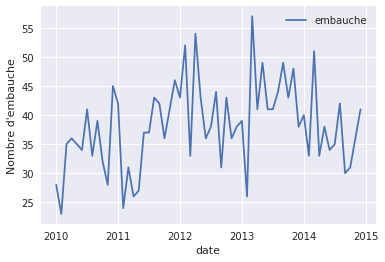

In [139]:
candidates['date'] = pd.to_datetime(candidates['date'], dayfirst=True)
groupeby_date = candidates.loc[:, ('date', 'embauche')].groupby('date').sum()

groupeby_date_mounth = groupeby_date.groupby(pd.Grouper(freq="M")).sum()

_ = groupeby_date_mounth.plot()
_ = plt.ylabel('Nombre d\'embauche')

Cette courbe de présente pas de périodicité significative. La date ne sera pas une information importante pour la prédiction de l'embauche ou non d'un candidat donné.

__Les cheveux et la note__

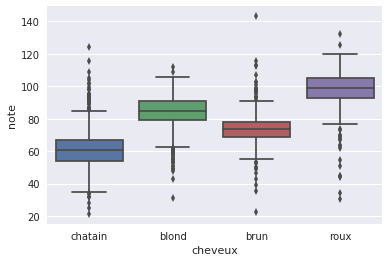

In [114]:
_ = sns.boxplot(x='cheveux', y='note', data=hired)

Une découverte étonnante, les candidats embauchés peuvent être classés par leur couleurs de cheveux et leur note. Par exemple, en visualisant le graphique ci-dessus, nous voyons que les candidats blond embauchés ont des notes entre 65 et 105 environ au test avec 50% des candidats ayant entre 80 et 90.

Les deux variables note et cheveux peuvent être utiles pour la prédictions d'une future embauche.

__Le salaire__

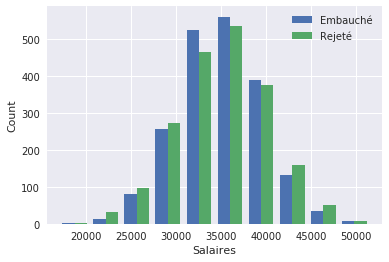

In [122]:
_ = plt.hist([hired.salaire.sample(n=2000), rejected.salaire.sample(n=2000).values])
_ = plt.legend(['Embauché', 'Rejeté'])
_ = plt.ylabel('Count')
_ = plt.xlabel('Salaires')

La distribution des salaires demandés des deux populations (embauché et rejeté) est équivalente. Une moyenne entre 34k et 35k. Cette variable ne nous donne pas d'informations importante.

__Diplome et spécialité__

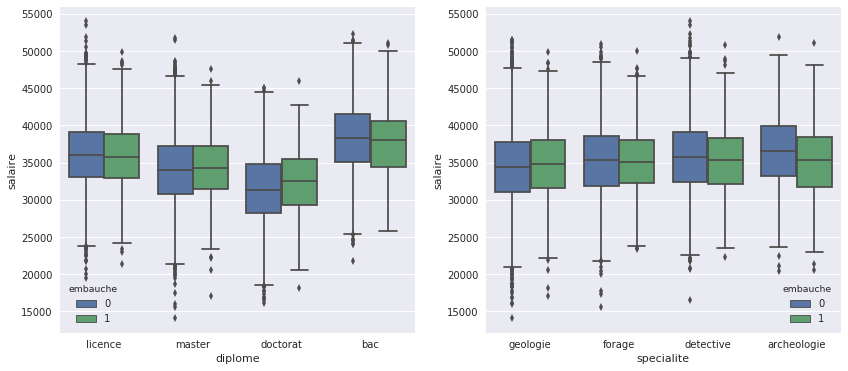

In [34]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 6))

_ = sns.boxplot(x='diplome', y='salaire', hue='embauche', data=candidates, ax=axs[0])
_ = sns.boxplot(x='specialite', y='salaire', hue='embauche', data=candidates, ax=axs[1])

D'après les visualisations ci-dessus, la distribution en salaire des candidats embauchés et des candidats non embauchés est assez similaire. Une différence de $\pm 1k$ en comparant les médiannes. 

Les salaires demandés varient beaucoup en fonction du diplome du candidat. Les candidats n'ayant que le bac ont tendance à demander des salaires plus élevés contraitement aux docteurs qui demandent des salaires plus faibles.

Concernant la spécialité, les distributions sont quasi équivalentes. Les archéologues demandent un peu plus que les autres spécialités.

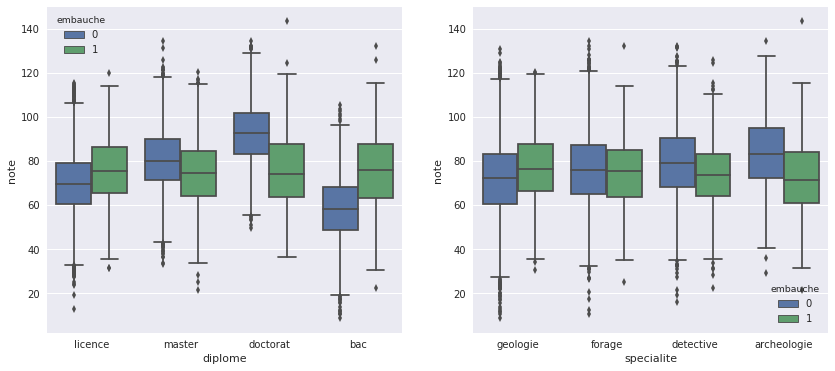

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 6))

_ = sns.boxplot(x='diplome', y='note', hue='embauche', data=candidates, ax=axs[0])
_ = sns.boxplot(x='specialite', y='note', hue='embauche', data=candidates, ax=axs[1])

Visualisons à présent la distribution des notes en fonction des diplomes et des spécialités des deux populations (embauchés et non embauchés). La différence est assez significative pour les diplômes, surtout pour les candidats ayant un bac et un doctorat. Une remarque étonnante pour la majorité des diplomes et spécialités, ces candidats ont tendance à être plus recrutés avec des notes plus faibles (doctorat, archéologue, détective...).

Ces deux variables note et diplome forment un couple intéressant pour la prédiction d'une future embauche.

### 2. Dépendance statistique entre les variables

__Le nombre d'année d'expérience et la note__

In [ ]:
def jitter(values, jitter=0.5):
    n = len(values)
    return np.random.uniform(-jitter, +jitter, n) + values

In [11]:
notes = candidates['note']
exp = candidates['exp']

In [18]:
notes_jit = jitter(notes)
exp_jit = jitter(exp)

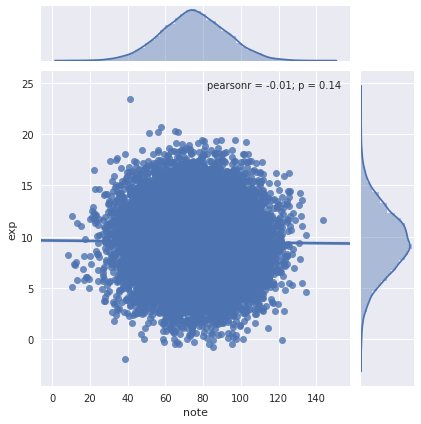

In [22]:
_ = sns.jointplot(x=notes_jit, y=exp_jit, kind='reg')

Aucune forme linéaire n'est observable via ce graphique. De plus le coefficient de corrélation pearsonr est égale à -0.01. 1 ou -1 signifie une corrélation parfaite, la majorité des corrélations dans la réalité ne sont pas parfaites et varient entre -0.8 et 0.8. Un coefficient de 0.5 signifie déjà une corrélation importante.

Le coefficient très proche de 0 nous indique donc aucune corrélation linéaire.

__La spécialité et le sexe__

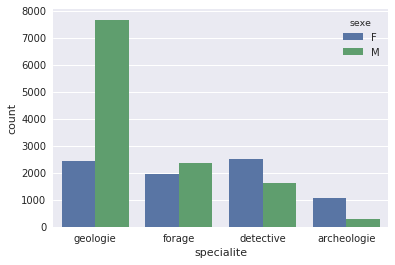

In [88]:
_ = sns.countplot(x='specialite', hue='sexe', data=candidates)

Une visualisation de la répartition des spécialités chez les deux populations (hommes et femmes) nous montre que la majorité des hommes choisissent la géologie comme spécialisation. Chez les femmes, la répartition est équilibrée avec une minorité pour l'archéologie aussi bien chez les femmes que les hommes.

In [79]:
from sklearn.preprocessing import LabelEncoder

lb_sexe = LabelEncoder()
lb_specialite = LabelEncoder()
df['sexe'] = lb_sexe.fit_transform(df['sexe'])
df['specialite'] = lb_specialite.fit_transform(df['specialite'])

In [86]:
df.corr(method='pearson')

,sexe,specialite
sexe,1.000000,0.365726
specialite,0.365726,1.000000


Le calcul du coefficient de Pearson renforce cette idée d'une corrélation existante, $\rho = 0.37$

__La couleur de cheveux et le salaire demandé__

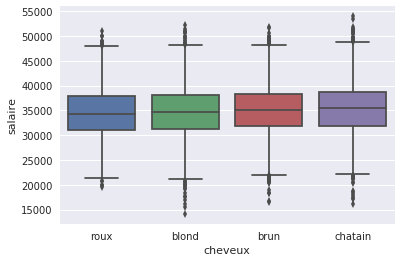

In [238]:
_ = sns.boxplot(x='cheveux', y='salaire', data=candidates)

In [138]:
from sklearn.preprocessing import LabelEncoder

df = candidates.copy()
lb_cheveux = LabelEncoder()
df['cheveux'] = lb_cheveux.fit_transform(df['cheveux'])

In [119]:
df.loc[:, ('cheveux', 'salaire')].corr(method='pearson')

,cheveux,salaire
cheveux,1.000000,-0.011653
salaire,-0.011653,1.000000


Peu importe la couleur de cheveux des candidats, le répartition des salaires demandé est la même. De plus le coefficient de correspondance proche de 0 confirme qu'il n'y a pas de corrélation apparente entre ces deux attributs.

### 3. Distribution en age

Calculer la CDF permet de comparer les distributions en age des deux populations (Homme et Femme). Une "cumulative distribution function" est une fonction qui relie une valeur à son "percentile rank". Pour une valeur donnée $x$, nous calculons la fraction correspondant au nombre de valeurs inférieurs ou égales à $x$.

Nous allons calculer Cdf(age) pour chaque age donnée des deux populations. Voici les 10 premières valeurs :

In [37]:
def get_cdf(sample, x):
    count = 0.0
    for value in sample:
        if value <= x:
            count += 1
    prob = count / len(sample)
    return prob

In [38]:
women = candidates[candidates['sexe'] == 'F']
men = candidates[candidates['sexe'] == 'M']

ages_men = men['age']
ages_women = women['age']

In [40]:
ages_men_cdf = [get_cdf(ages_men, x) for x in ages_men.sort_values()]
ages_women_cdf = [get_cdf(ages_women, x) for x in ages_women.sort_values()]

pprint('Homme : {}'.format(ages_men_cdf[:10]))
pprint('Femme : {}'.format(ages_women_cdf[:10]))

('Homme : [0.0004170489615480857, 0.0004170489615480857, '
 '0.0004170489615480857, 0.0004170489615480857, 0.0004170489615480857, '
 '0.00058386854616732, 0.00058386854616732, 0.001084327300025023, '
 '0.001084327300025023, 0.001084327300025023]')
('Femme : [0.00012482836100362001, 0.00024965672200724003, '
 '0.0004993134440144801, 0.0004993134440144801, 0.0009986268880289601, '
 '0.0009986268880289601, 0.0009986268880289601, 0.0009986268880289601, '
 '0.0012482836100362001, 0.0012482836100362001]')


Nous pouvons à présent afficher ces deux séquences sur un graphique afin de visualiser la forme de la courbe obtenue.

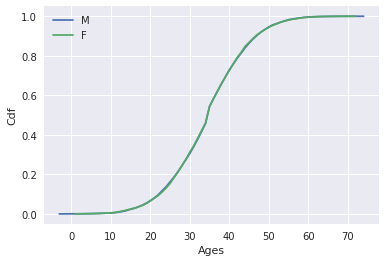

In [108]:
_= plt.plot(ages_men.sort_values(), ages_men_cdf, ages_women.sort_values(), ages_women_cdf)
_ = plt.ylabel('Cdf')
_ = plt.xlabel('Ages')
_ = plt.legend(['M', 'F'])

Les deux courbes représentant la distribution en âge des deux populations se superposent, ainsi nous pouvons affirmer que ces deux distributions sont identiques.

## 2. Machine learning

### 1. Choix du modèle

Le Random Forest est un algorithme de machine learning basé sur les arbres de décision. Utilisé pour de l'apprentissage supervisé, il performe aussi bien pour de la régression ou de la classification. Dans notre cas, nous devons prédire une variable catégorique : 
> "Est-ce que le candidat sera embauché ?" 1 ou 0. 

C'est donc un problème de __Classification__.

Dans un premier temps, procédons à une sélection des variables pour notre modèle. Les colonnes contenant des valeurs catégoriques doivent être converties pour pouvoir être utilisée convenablement (ex: "dispo" -> oui ou non). Utilisons la méthode du __One-Hot-Encoding__ grâce à la fonction "get_dummies" de Pandas qui convertie ces colonnes en plusieurs sous colonnes comprenant les valeurs 0/1.

In [5]:
# Create a copy of original candidates dataframe
data = candidates.copy()

# Select categorical columns
dummy_columns = ['sexe', 'specialite', 'cheveux', 'dispo', 'diplome']
for each in dummy_columns:
    dummies = pd.get_dummies(data[each], prefix=each, drop_first=False)
    data = pd.concat([data, dummies], axis=1)

# drop old and useless columns
columns_to_drop = ['date', 'cheveux', 'sexe', 'diplome', 'specialite', 'dispo', 'age']
data = data.drop(columns_to_drop, axis=1).copy()
data.head()

,exp,salaire,note,embauche,sexe_F,sexe_M,specialite_archeologie,specialite_detective,specialite_forage,specialite_geologie,cheveux_blond,cheveux_brun,cheveux_chatain,cheveux_roux,dispo_non,dispo_oui,diplome_bac,diplome_doctorat,diplome_licence,diplome_master
0,9.0,26803.0,97.08,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0
1,13.0,38166.0,63.86,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0
2,13.0,35207.0,78.50,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0
3,12.0,32442.0,45.09,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0
4,6.0,28533.0,81.91,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0


### 2. Critères de performance

Dans un deuxième temps, nous allons diviser notre jeu de donné:

- Dataset d'entrainement (70%)
- Dataset de test (30%)

Ainsi nous pourrons évaluer si notre modèle overfit le jeu d'entrainement. En le testant sur des données qu'il n'a jamais apperçu, nous saurons si il a vraiment trouvé un pattern dans le jeu d'entrainement ou si il a seulement appris par coeur les données reçues.

In [6]:
from sklearn.model_selection import train_test_split

target_columns = ['embauche']
features, target = data.drop(target_columns, axis=1), data[target_columns]
train_features, test_features, train_target, test_target = train_test_split(
        features, target, test_size=0.30)

Nous avons à présent notre modèle, nos jeu de donnée d'entrainement et de test. Le Random Forest est basé sur les arbres de décision. Il produit plusieurs arbres afin de classifier un élément basé sur ses attributs. Ces arbres de décision peuvent être paramétrés pour obtenir des résultats différents. Nous allons modifier les principaux paramètres:

- n_estimators : Nombre d'arbres dans la forêt
- max_features : Nombre de variables à considérer à chaque division
- max_depth : Nombre maximum de niveau pour chaque arbre
- min_samples_split : Nombre minimum de valeurs requis pour diviser un noeud
- min_samples_leaf : Nombre minimum de valeurs requis pour chaque leaf node
- bootstrap : Méthode de sélection de valeurs pour l'entrainement des noeuds

Trouver le bon paramétrage est souvent le résultat d'une étude longue et fastidieuse. Une approche plus rapide basé sur des tests aléatoires permet un paramétrage correct et rapide du modèle : __Random Search Cross Validation__

Nous définissons des intervalles de valeurs pour les différentes paramètes

In [7]:
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200]}


En utilisant une instance RandomizedSearchCV de la librairie sklearn, nous allons à chaque itération choisir une combinaison différente parmis celles fournies précédemment. A l'issue de ce traitement, le choix de la meilleure combinaison sera fait en utilisant l'attribut rf_random.best\_params_ .

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf, refit=True, param_distributions=random_grid, 
                               n_iter=100, cv=3, verbose=0, random_state=42, n_jobs=-1)

In [80]:
# Compute our random search to get best parameters
rf_random.fit(train_features[:].values, train_target['embauche'].values)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'bootstrap': [True, False], 'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [87]:
print('Meilleurs paramètres:')
rf_random.best_params_

Meilleurs paramètres:


{'bootstrap': False,
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 136}

Nous pouvons maintenant créer notre modèle en utilisant les paramètres obtenus à l'aide du 'Random Search Cross Validation'

In [32]:
# Init our model with parameters found previously
rf = RandomForestClassifier(max_features='sqrt', n_estimators=136, 
                            max_depth=80, min_samples_split=2,
                            min_samples_leaf=4, bootstrap=False)
pprint('Paramètre de notre model : {}'.format(rf.get_params()))

("Paramètre de notre model : {'warm_start': False, 'class_weight': None, "
 "'max_depth': 80, 'min_weight_fraction_leaf': 0.0, 'oob_score': False, "
 "'random_state': None, 'criterion': 'gini', 'n_jobs': 1, 'bootstrap': False, "
 "'min_impurity_decrease': 0.0, 'verbose': 0, 'min_samples_split': 2, "
 "'min_samples_leaf': 4, 'max_leaf_nodes': None, 'min_impurity_split': None, "
 "'n_estimators': 136, 'max_features': 'sqrt'}")


Après entrainement du modèle, nous pouvons le tester sur notre jeu de donnée de test. Voici les résultats ci-dessous:

In [69]:
print('Fit... and Predict...')
prediction = rf.fit(train_features[:].values, train_target['embauche'].values).predict(test_features[:].values)
print('==> predict: ')
reality = test_target[:].values
result = pd.DataFrame({'prediction': prediction, 'reality': test_target['embauche']})
result['get_it'] = 'nop'
result.loc[result.prediction == result.reality, 'get_it'] = 'yes'
print(result[30:50])
print('  == get_it:')
print(result.get_it.value_counts())
# Print score for test and train features
print('Score on train dataset : {0:.3f}\n'
      'Score on test dataset : {1:.3f}\n'.format(rf.score(train_features, train_target),
                                            rf.score(test_features, test_target)))

Fit... and Predict...
==> predict: 
       prediction  reality get_it
13272           0        0    yes
5890            0        0    yes
16685           0        0    yes
18541           0        0    yes
7053            0        0    yes
2758            0        0    yes
3967            0        0    yes
8306            0        0    yes
15092           0        0    yes
17477           0        1    nop
11436           0        0    yes
6070            0        1    nop
16488           0        0    yes
12501           1        1    yes
4741            0        0    yes
5106            0        0    yes
19791           0        0    yes
15593           0        0    yes
13731           1        1    yes
3349            0        0    yes
  == get_it:
yes    5552
nop     448
Name: get_it, dtype: int64
Score on train dataset : 0.957
Score on test dataset : 0.925



### 3. Améliorations

Notre Random Forest peut être améliorer en :

- Sélectionnant de manière plus précise les variables.
- Utilisant une méthode moins aléatoire de paramétrage du modèle.
- Ajoutant des données complémentaires aux données déjà fournies (motivation des candidats...).